In [1]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected
%matplotlib inline

In [2]:
# SETUP

MU = -1
SIGMA = 1
RANGE = 5

G_INPUT_SIZE = 1
D_INPUT_SIZE = 1
D_OUTPUT_SIZE = 1
HIDDEN_SIZE = 4

BATCH_SIZE = 20 
LEARNING_RATE = 0.005
EPOCHS = 20000

BIN_COUNT = 50
RESOLUTION = 20000
VALIDATIONS_COUNT = 10

In [3]:
# INIT

def z_sample(shape):
    size = 1
    for dim in shape:
        size *= dim
    return np.reshape(np.linspace(-RANGE, RANGE, size) + np.random.random(size), shape)


def x_sample(shape):
    return np.random.normal(MU, SIGMA, shape)


def generator(z):
    hidden_1 = fully_connected(z, HIDDEN_SIZE, activation_fn=tf.nn.softplus)
    output = fully_connected(hidden_1, D_INPUT_SIZE, activation_fn=None)
    return output
    # scaled_output = tf.multiply(output, RANGE)
    # return scaled_output


def discriminator(x):
    hidden_1 = fully_connected(x, HIDDEN_SIZE * 2, activation_fn=tf.tanh, scope='h1', reuse=True)
    hidden_2 = fully_connected(hidden_1, HIDDEN_SIZE * 2, activation_fn=tf.tanh, scope='h2', reuse=True)
    hidden_3 = fully_connected(hidden_2, HIDDEN_SIZE * 2, activation_fn=tf.tanh, scope='h3', reuse=True)
    output = fully_connected(hidden_3, D_OUTPUT_SIZE, activation_fn=tf.sigmoid, scope='out', reuse=True)
    return output

In [4]:
def plot_fig(session):
    # p_data
    xs = x_sample(RESOLUTION)
    hist, edges = np.histogram(xs, bins=BIN_COUNT, range=(-RANGE, RANGE), density=True)
    plt.plot(np.linspace(-RANGE, RANGE, BIN_COUNT), hist, label='p_data')

    # decision boundary
    xs = np.reshape(np.linspace(-RANGE, RANGE, RESOLUTION), (-1, D_INPUT_SIZE))
    ds = session.run(D1, {x: xs})
    plt.plot(xs, ds, label='decision boundary')

    # distribution of inverse-mapped points
    zs = np.linspace(-RANGE, RANGE, RESOLUTION)
    gs = session.run(G, feed_dict={z: np.reshape(zs, (-1, G_INPUT_SIZE))})
    hist, edges = np.histogram(gs, bins=BIN_COUNT, range=(-RANGE, RANGE), density=True)
    plt.plot(np.linspace(-RANGE, RANGE, BIN_COUNT), hist, label='p_g')

    # ylim, legend
    plt.ylim(0, 1.1)
    plt.legend()

D params count: 8
G params count: 4
(1, 4)
(4,)
(4, 1)
(1,)


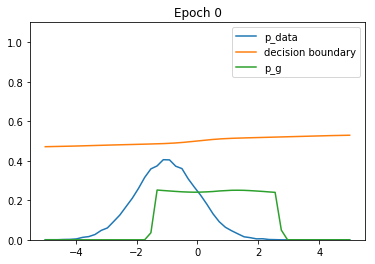

Epoch 0: loss_d=1.4165892601013184 loss_g=0.688560962677002


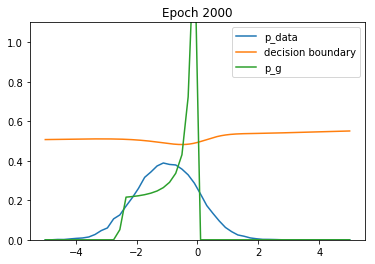

Epoch 2000: loss_d=1.3735451698303223 loss_g=0.7098928093910217


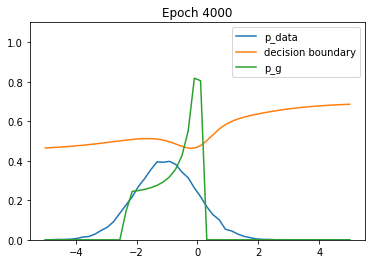

Epoch 4000: loss_d=1.3515026569366455 loss_g=0.7215656042098999


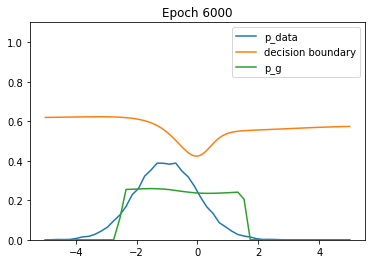

Epoch 6000: loss_d=1.4173758029937744 loss_g=0.6283961534500122


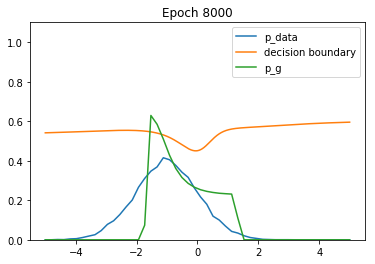

Epoch 8000: loss_d=1.3760566711425781 loss_g=0.6669694781303406


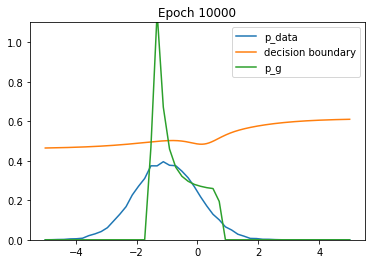

Epoch 10000: loss_d=1.3922743797302246 loss_g=0.6981348991394043


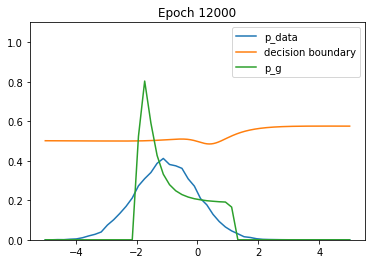

Epoch 12000: loss_d=1.3876562118530273 loss_g=0.6876637935638428


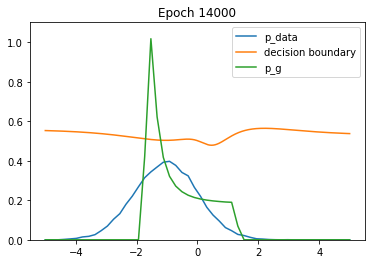

Epoch 14000: loss_d=1.3752119541168213 loss_g=0.6846797466278076


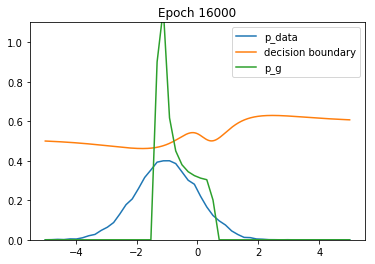

Epoch 16000: loss_d=1.4082237482070923 loss_g=0.7043968439102173


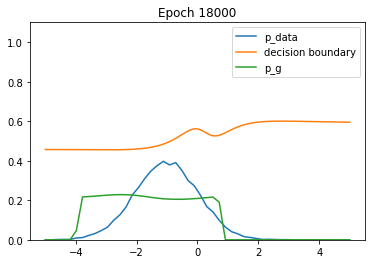

Epoch 18000: loss_d=1.3570284843444824 loss_g=0.7255756855010986


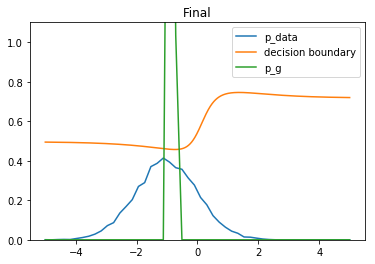

In [5]:
with tf.device('/gpu:0'):
    with tf.variable_scope('G'):
        z = tf.placeholder(tf.float32, shape=(None, G_INPUT_SIZE))
        G = generator(z)

    with tf.variable_scope('D') as scope:
        x = tf.placeholder(tf.float32, shape=(None, D_INPUT_SIZE))
        D1 = discriminator(x)
        scope.reuse_variables()
        D2 = discriminator(G)

    loss_d = tf.reduce_mean(-tf.log(D1) - tf.log(1 - D2))
    loss_g = tf.reduce_mean(-tf.log(D2))

    trainable_vars = tf.trainable_variables()
    d_params = [v for v in trainable_vars if v.name.startswith('D/')]
    g_params = [v for v in trainable_vars if v.name.startswith('G/')]
    print("D params count: {}".format(len(d_params)))
    print("G params count: {}".format(len(g_params)))
    print("\n".join(list(map(lambda param: str(param.get_shape()), g_params))))

    opt_d = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss_d, var_list=d_params)
    opt_g = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss_g, var_list=g_params)

with tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)) as session:
    session.run(tf.global_variables_initializer())

    for step in range(EPOCHS):
        if step % (EPOCHS // VALIDATIONS_COUNT) == 0:
            plot_fig(session)
            plt.title('Epoch {}'.format(step))
            plt.show()

        xs = x_sample([BATCH_SIZE, D_INPUT_SIZE])
        zs = z_sample([BATCH_SIZE, G_INPUT_SIZE])
        loss_ds, _ = session.run([loss_d, opt_d], feed_dict={x: xs, z: zs})
        
        zs = z_sample([BATCH_SIZE, G_INPUT_SIZE])
        loss_gs, _ = session.run([loss_g, opt_g], feed_dict={z: zs})
        
        if step % (EPOCHS // VALIDATIONS_COUNT) == 0:
            print('Epoch {}: loss_d={} loss_g={}'.format(step, loss_ds, loss_gs))

    plot_fig(session)
    plt.title('Final')
    plt.show()